In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import matplotlib.pyplot as plt

import random
from datetime import datetime

In [2]:
solvent_data = pd.read_excel('/Users/jlisd/Downloads/AI Chem/AI Chem/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'solvent')
solvent_data.set_index('solvent_name', inplace = True)
solvent_columns = list(solvent_data.columns)

In [3]:
nucleophile_data = pd.read_excel('/Users/jlisd/Downloads/AI Chem/AI Chem/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'nucleophiles')
nucleophile_data.set_index('nucleophile_name', inplace = True)
nucleophile_columns = list(nucleophile_data.columns)

In [4]:
raw_catalyst_data = pd.read_excel('/Users/jlisd/Downloads/AI Chem/AI Chem/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'model_catalyst')
raw_catalyst_data.rename(columns = {'Unnamed: 1': 'catalyst_name'}, inplace = True)

r_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    r_catalyst_data.iloc[i, 1] = r_catalyst_data.iloc[i, 1].replace('R/S', 'R')

s_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    s_catalyst_data.iloc[i, 1] = s_catalyst_data.iloc[i, 1].replace('R/S', 'S')

catalyst_data = pd.concat([r_catalyst_data, s_catalyst_data])
catalyst_data.set_index('catalyst_name', inplace = True)
catalyst_columns = list(catalyst_data.columns)

In [5]:
raw_catalyst_data = pd.read_excel('/Users/jlisd/Downloads/AI Chem/AI Chem/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'full_catalyst')
raw_catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)

#Taking care of catalyst R/S
r_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    r_catalyst_data.iloc[i, 1] = r_catalyst_data.iloc[i, 1].replace('R/S', 'R')
    #print(r_catalyst_data.iloc[i, 1])
#r_catalyst_data.drop(17, inplace = True)    

s_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    s_catalyst_data.iloc[i, 1] = s_catalyst_data.iloc[i, 1].replace('R/S', 'S')
    #print(s_catalyst_data.iloc[i, 1])
    
catalyst_data = pd.concat([r_catalyst_data, s_catalyst_data])
catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)
catalyst_data.set_index('catalyst_name', inplace = True)

catalyst_columns = list(catalyst_data.columns)

In [6]:
iminium_data = pd.read_excel('/Users/jlisd/Downloads/AI Chem/AI Chem/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'iminiums')
iminium_data.rename(columns = {'imine': 'iminium_name', 'electronic energy difference (kcal/mol) ': 'electronic energy difference (kcal/mol)'}, inplace = True)
#removed space at the end of electronic energy
iminium_data.set_index('iminium_name', inplace = True)
iminium_data.drop(labels = ['Unnamed: 1'], axis = 1, inplace = True)
for i in range(1, 181):
    z_iminium_name = '(Z)-Iminium ' + str(i)
    e_iminium_name = '(E)-Iminium ' + str(i)
    iminium_data.loc[z_iminium_name, 'electronic energy difference (kcal/mol)'] = iminium_data.loc[e_iminium_name, 'electronic energy difference (kcal/mol)']
iminium_columns = list(iminium_data.columns)

In [7]:
class Reaction():
    
    def __init__(self, name, entry, catalyst, nucleophile, substrate, solvent, iminium_type, iminium, majorenantiomer, minorenantiomer, ee, G):
        self.name = name
        self.entry = entry
        self.catalyst = catalyst
        self.nucleophile = nucleophile
        self.substrate = substrate
        self.solvent = solvent
        self.iminium_type = iminium_type
        self.iminium = iminium
        self.majorenantiomer = majorenantiomer
        self.minorenantiomer = minorenantiomer
        self.ee = ee
        self.G = G
            
        self.solvent_properties = dict()
        for column in solvent_columns:
            self.solvent_properties[column] = solvent_data.loc[solvent, column]
            
        self.catalyst_properties = dict()
        for column in catalyst_columns:
            self.catalyst_properties[column] = catalyst_data.loc[catalyst, column]
            
        self.nucleophile_properties = dict()
        for column in nucleophile_columns:
            self.nucleophile_properties[column] = nucleophile_data.loc[nucleophile, column]
        
        self.e_iminium = '(E)-' + str(iminium)
        self.z_iminium = '(Z)-' + str(iminium)
        
        self.e_iminium_properties = dict()
        self.z_iminium_properties = dict()
        for column in iminium_columns:
            self.e_iminium_properties[column] = iminium_data.loc[self.e_iminium, column]
            self.z_iminium_properties[column] = iminium_data.loc[self.z_iminium, column]
            
        
            
    def __repr__(self):
        return "Reaction - {}".format(self.name)
        #iminium stuff

In [8]:
reactions = dict()

def process_data(reaction_number, reaction, iminium_type, sheetname = None):
    reaction_file = '/Users/jlisd/Downloads/AI Chem/AI Chem/reaction info 5-23/' + str(reaction_number) + ' ' + reaction + '.xlsx'
    if sheetname == None:
        data = pd.read_excel(reaction_file)
    else:
        data = pd.read_excel(reaction_file, sheet_name = sheetname)
        
    data.set_index('entry', inplace = True)
    
    entries = len(data)
    for entry in range(1, entries + 1):
        if sheetname == None:
            reaction_name = reaction + ' ' + str(entry)
        else:
            reaction_name = reaction + ' ' + sheetname + ' ' + str(entry)
        
        
        reactions[reaction_name] = Reaction(reaction_name, 
                                            entry,
                                            data.loc[entry, 'Catalyst'],
                                            data.loc[entry, 'Nucleophile'],
                                            data.loc[entry, 'Substrate'],
                                            data.loc[entry, 'Solvent'],
                                            iminium_type,
                                            data.loc[entry, 'Iminium'],
                                            data.loc[entry, 'Major Enantiomer'],
                                            data.loc[entry, 'Minor Enantiomer'],
                                            data.loc[entry, 'ee'],
                                            data.loc[entry, 'ΔΔG‡'])
        


In [9]:
process_data(1, 'Addition of Alcohols', 'E', 'Scope')
process_data(2, 'Addition of thiols', 'E', 'Catalyst & solvent screening da')
process_data(2, 'Addition of thiols', 'E', 'Effect of catalyst loading')
process_data(2, 'Addition of thiols', 'E', 'Imine scope')
process_data(2, 'Addition of thiols', 'E', 'Thiol scope')
process_data(3, 'Hydrophosphonylation of imines', 'E', 'Catalyst screening data')
process_data(3, 'Hydrophosphonylation of imines', 'E', 'Scope')
process_data(4, 'Addition of diazomethylphosphonates', 'E', "Optimization of catalyst and re")
process_data(4, 'Addition of diazomethylphosphonates', 'E', "Imine scope")
process_data(5, 'Addition of diazoacetamides', 'E', 'Catalyst screening data')
process_data(5, 'Addition of diazoacetamides', 'E', 'Solvent screening data')
process_data(5, 'Addition of diazoacetamides', 'E', 'Substrate(s) scope')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Catalyst screening data')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Solvent screening data')
process_data(6, 'Strecker Reaction (with aldimines)', 'E', 'Imine scope')
process_data(7, 'Peroxidation of imines', 'E', 'Catalyst screening data')
process_data(7, 'Peroxidation of imines', 'E', 'Solvent screening data')
process_data(7, 'Peroxidation of imines', 'E', 'Substrate(s) scope')
process_data(8, 'Transfer Hydrogenation of b,g-Alkynyl a-Imino Esters', 'E', 'Catalyst screening and reaction')
process_data(8, 'Transfer Hydrogenation of b,g-Alkynyl a-Imino Esters', 'E', 'Scope')
process_data(9, 'Transfer Hydrogenation of Enamides', 'E', 'Scope')
process_data(10, 'Transfer Hydrogenation of N-aryl imines (List)', 'Z', 'Catalyst screening data')
process_data(10, 'Transfer Hydrogenation of N-aryl imines (List)', 'Z', 'Imine scope')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Catalyst screening data')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Solvent screening data')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Z', 'Imine scope')
process_data(12, 'Reductive amination of N-aryl imines (Macmillan)', 'Z', 'Reaction optimization')
process_data(13, 'Transfer Hydrogenation of trifluoromethyl ketimines', 'Z', 'Benzothiazoline screening data')
process_data(13, 'Transfer Hydrogenation of trifluoromethyl ketimines', 'Z', 'Imine scope')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Catalyst screening data')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Benzothiazoline screening data')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Z', 'Imine scope')
process_data(15, 'Reductive amination of aliphatic ketones by benzothiazoline', 'Z', 'Catalyst screening data')
process_data(15, 'Reductive amination of aliphatic ketones by benzothiazoline', 'Z', 'Imine scope')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Benzothiazoline screening data')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Scope 1 benzothiazoline')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Z', 'Scope 2 dihydropyridine')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Catalyst screening data')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Solvent data')
process_data(17, 'Strecker Reaction (with ketimines)', 'Z', 'Imine scope')
#process_data(18, 'Addition of enecarbamates to benzoyl imines')
#process_data(19, 'Hydrogenation of fluorinated alkynyl ketimines')
#process_data(20, 'Addition of thiols to imines (Denmark)')

In [19]:
catalyst = pd.DataFrame(columns = ['Reaction'] + catalyst_columns)
catalyst.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in catalyst_columns:
        catalyst.loc[reaction, column] = reactions[reaction].catalyst_properties[column]
#first column is numerical

In [20]:
catalyst.head()

,Ar group,arhs,alhs,aavg,b,AREA(q),sin(AREA),Lwhole R,B1whole R,B5whole R,...,C3 A,C4 A,C5 A,C6 A,nPOsy,iPOsy,nPOas,iPOas,P,PNMR
Reaction,,,,,,,,,,,,,,,,,,,,,
Addition of Alcohols Scope 1,9-Anthryl,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,...,-0.054,-0.162,-0.059,-0.049,1088.24,321.983,1324.49,223.989,2.539,268.953
Addition of Alcohols Scope 2,9-Anthryl,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,...,-0.054,-0.162,-0.059,-0.049,1088.24,321.983,1324.49,223.989,2.539,268.953
Addition of Alcohols Scope 3,9-Anthryl,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,...,-0.054,-0.162,-0.059,-0.049,1088.24,321.983,1324.49,223.989,2.539,268.953
Addition of Alcohols Scope 4,9-Anthryl,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,...,-0.054,-0.162,-0.059,-0.049,1088.24,321.983,1324.49,223.989,2.539,268.953
Addition of Alcohols Scope 5,9-Anthryl,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,...,-0.054,-0.162,-0.059,-0.049,1088.24,321.983,1324.49,223.989,2.539,268.953


In [40]:
iposy = catalyst.loc[:, 'iPOsy']
L2_A = catalyst.loc[:, 'L2 A']
b = catalyst.loc[:, 'b']

In [12]:
nucleophile = pd.DataFrame(columns = ['Reaction'] + nucleophile_columns)
nucleophile.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in nucleophile_columns:
        nucleophile.loc[reaction, column] = reactions[reaction].nucleophile_properties[column]
        
#first column is numerical

In [13]:
solvent = pd.DataFrame(columns = ['Reaction'] + solvent_columns)
solvent.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in solvent_columns:
        solvent.loc[reaction, column] = reactions[reaction].solvent_properties[column]
        
#first column is numerical

In [14]:
iminium = pd.DataFrame(columns = ['Reaction', "iminium_type"] + iminium_columns)
iminium.set_index('Reaction', inplace = True)

for reaction in reactions:
    if reactions[reaction].iminium_type == 'E':
        iminium.loc[reaction, "iminium_type"] = 'E'
        for column in iminium_columns:
            iminium.loc[reaction, column] = reactions[reaction].e_iminium_properties[column]
    elif reactions[reaction].iminium_type == 'Z':
        iminium.loc[reaction, "iminium_type"] = 'Z'
        for column in iminium_columns:
            iminium.loc[reaction, column] = reactions[reaction].z_iminium_properties[column]
            

In [15]:
print(iminium.shape, solvent.shape, nucleophile.shape, raw_catalyst_data.shape)

(381, 22) (381, 160) (381, 15) (18, 86)


In [16]:
#iminium nucleophile solvent
X_INS = pd.concat([nucleophile.drop(['nucleophile'], axis = 1), 
               solvent.drop(['solvent'], axis = 1),
              iminium.drop(['iminium_type'], axis = 1)], axis = 1)
X_INS.head()

,H (nucleophile),X,Nu,nXH,iXH,HOMO (nucleophile),LUMO (nucleophile),Polarizability (nucleophile),L,B1,...,SL,SB1,SB5,LL,LB1,LB5,HOMO (iminium),LUMO (iminium),Polarizability (iminium),electronic energy difference (kcal/mol)
Reaction,,,,,,,,,,,,,,,,,,,,,
Addition of Alcohols Scope 1,0.458,-0.707,-0.707,3899.4,40.1897,-0.35328,0.0626,18.27,3.99,1.4,...,2.58,1.09,1.09,6.76,1.7,3.39,-0.44273,-0.23633,180.99,6.67
Addition of Alcohols Scope 2,0.464,-0.717,-0.717,3893.54,39.6036,-0.34808,0.06264,30.23,5.03,1.2,...,2.58,1.09,1.09,6.76,1.7,3.39,-0.44273,-0.23633,180.99,6.67
Addition of Alcohols Scope 3,0.461,-0.717,-0.717,3877.1,28.7764,-0.34588,0.05777,42.01,5.03,1.13,...,2.58,1.09,1.09,6.76,1.7,3.39,-0.44273,-0.23633,180.99,6.67
Addition of Alcohols Scope 4,0.459,-0.722,-0.722,3859.15,22.2253,-0.34415,0.05141,53.61,5.03,1.44,...,2.58,1.09,1.09,6.76,1.7,3.39,-0.44273,-0.23633,180.99,6.67
Addition of Alcohols Scope 5,0.471,-0.704,-0.704,3851.9,43.4805,-0.3582,0.05955,40.75,3.98,1.4,...,2.58,1.09,1.09,6.76,1.7,3.39,-0.44273,-0.23633,180.99,6.67


In [17]:
#iminium nucleophile
X_IN = pd.concat([iminium.drop(['iminium_type'], axis = 1),
                nucleophile.drop(['nucleophile'], axis = 1)], axis = 1)
X_IN.head()

,nNH,i NH,N,H (iminium),C,SubL,SubS,PG,PGL,PGB1,...,iXH,HOMO (nucleophile),LUMO (nucleophile),Polarizability (nucleophile),L,B1,B5,bond distance H-X,H-X-Nu,H-X-CNu
Reaction,,,,,,,,,,,,,,,,,,,,,
Addition of Alcohols Scope 1,3569.31,83.7481,-0.533,0.427,0.306,-0.2,0.255,0.69,6.63,1.7,...,40.1897,-0.35328,0.0626,18.27,3.99,1.4,3.17,0.96,180,180
Addition of Alcohols Scope 2,3569.31,83.7481,-0.533,0.427,0.306,-0.2,0.255,0.69,6.63,1.7,...,39.6036,-0.34808,0.06264,30.23,5.03,1.2,3.41,0.96,180,180
Addition of Alcohols Scope 3,3569.31,83.7481,-0.533,0.427,0.306,-0.2,0.255,0.69,6.63,1.7,...,28.7764,-0.34588,0.05777,42.01,5.03,1.13,4.45,0.96,180,180
Addition of Alcohols Scope 4,3569.31,83.7481,-0.533,0.427,0.306,-0.2,0.255,0.69,6.63,1.7,...,22.2253,-0.34415,0.05141,53.61,5.03,1.44,4.44,0.96,180,180
Addition of Alcohols Scope 5,3569.31,83.7481,-0.533,0.427,0.306,-0.2,0.255,0.69,6.63,1.7,...,43.4805,-0.3582,0.05955,40.75,3.98,1.4,4.44,0.96,180,180


In [18]:
#iminium
X_I = iminium.drop(['iminium_type'], axis = 1)

############################################################################################################################

End of Data Processsing

############################################################################################################################

In [41]:
test_size = 0.5
random_state = random.seed(datetime.now())
X = X_INS
#X_INS, X_IN, or X_I
Y = b

In [42]:
forest = RandomForestRegressor()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = random_state)

forest.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = forest.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']

print('MSE: ' + str(mean_squared_error(Y_test, Y_pred)))
print('r^2: ' + str(r2_score(Y_test, Y_pred)))
results.head()

Y_train_pred = forest.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
train_results.set_index('Reaction', inplace = True)
train_results.columns = ['Actual', 'Predicted']
train_results

all_results = pd.concat([train_results, results])
all_results
print('Total r^2 score: ' + str(r2_score(all_results['Actual'], all_results['Predicted'])))

MSE: 0.2803288933410881
r^2: 0.6680389411316194
Total r^2 score: 0.7549218544881169


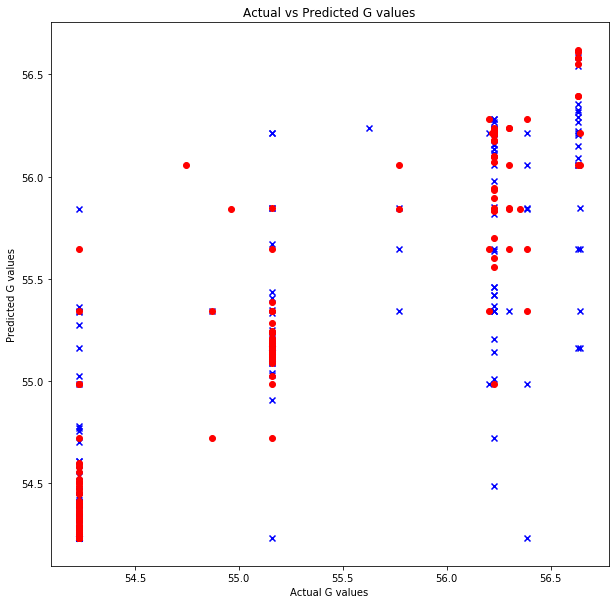

In [44]:
plt.scatter(results['Actual'], results['Predicted'], color = 'b', marker = 'x')
plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r', marker = 'o')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
#plt.plot(x, x)
plt.title('Actual vs Predicted G values')
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')
plt.rcParams['figure.figsize'] = [10,10]
plt.show()

###############################################################################################################################

Run Model 100 times

###############################################################################################################################